# 0. 인트로

Anomaly Detection 
본 실습 파일은 우선 다음의 대표적이고 기본적인 Anomaly Detection 방법론 3가지를 다룬다.  
-	Gaussian Density-based Anomaly Detection
-	Mixture of Gaussians Density Estimation
-	Auto Encoder


각각의 모델을 구현해보는 실습 이후에는 위 방법론들을 함께 사용하는 비교적 고도화된 모델 DAGMM(Zong, 2018) 모델을 다룬다.

-	DAGMM (Zong et al., ICLR 2018)

각각의 모델에 대한 이론적 내용을 가볍게 설명하고, 실제 python 코드로 실험을 수행하는 과정으로 진행되며, 기본적으로 동일한 데이터에 대한 각 모델의 결과를 비교하는 과정을 포함한다.

# 1. 이론 및 코드 구현
## 1.1	Anomaly Detection
Anomaly Detection은 이름에서 알 수 있듯이 Anomaly Data를 찾아내는 Task로 정상 데이터와 비정상 데이터를 구분해 내는 Task로 이해할 수 있다. 그렇다면 2 class Classification과 동일하게 느껴 질 수도 있는데, 두 Task는 다음과 같은 차이가 있다. 

 <p align="center">   <image src="./images/2022-11-16-23-39-00.png" width="60%"/>   </p>

Classification의 경우 각 클래스 별 데이터가 존재하고, 데이터의 label을 활용하여 해당 class를 예측하도록 학습이 된다. 그러나 Anomaly Detection의 경우에는 학습 상황에서는 정상의 데이터만 존재한다는 가정에서 정상 데이터의 특징을 파악할 수 있도록 학습되고, Test 상황에서 학습 과정에서 보지 못한 Anomaly data를 구분하는 과정이다.  

즉, two-class Classification의 경우 두가지 범주를 명시적으로 구분하는 것으로 한 class가 아니라면 반드시 다른 class인 상황이며, Anomaly Detection은 학습에 확인한 데이터와 동일한 성질의 데이터인지 아닌지 만을 판단하는 것이다. 즉, Anomaly라고 하더라도 엄밀히 말하면 불량 혹은 비정상 데이터인 것이 아니라 단지 학습에 보지 못한 새로운 성질의 데이터라고 하는 것이 옳다.  

Anomaly Detection의 방식은 크게 두 가지로 구분할 수 있는데, 첫째로는 학습 데이터를 통해 정상 데이터의 특징을 파악하고, 새로운 데이터에 대해서 원래 데이터와의 차이 등을 Anomaly score로 계산하여 특정 threshold를 넘으면 Anomaly로 판단하는 경우가 있다. 이번에 실습으로 알아볼 4가지 방법론들은 모두 이 첫번째 case에 해당한다. 두 번 째로는 방법론이 normal/Anomaly 데이터를 구분하는 명시적인 경계면을 생성해 주는 경우이다. 1-SVM이나 SVDD 방법론이 이 경우에 해당한다.  

 <p align="center">   <image src="./images/2022-11-16-23-39-27.png" width="60%"/>   </p>

In [144]:
# 이후의 모델 구현을 위한 라이브러리 및 데이터 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
# from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
# from sklearn.metrics import recall_score , average_precision_score
# from sklearn.metrics import precision_score, precision_recall_curve
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import precision_recall_fscore_support

import tqdm
import time


In [2]:
# 데이터 불러오기: 본 데이터는 신용카드 거래 데이터로 다음과 같은 변수를 포함한다.
df = pd.read_csv("creditcard.csv")
print(df.columns.values)

['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12'
 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24'
 'V25' 'V26' 'V27' 'V28' 'Amount' 'Class']


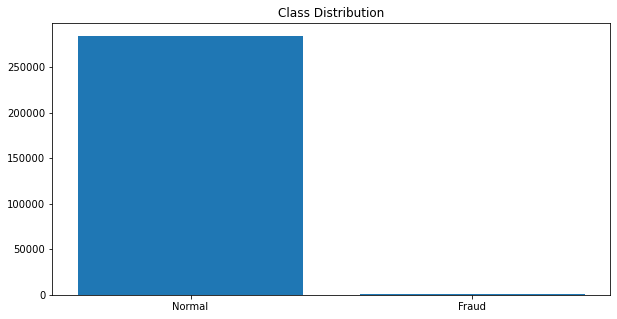

In [3]:
# 변수중 Class가 사기 거래인지 여부로 1이면 사기, 0이면 정상 거래를 의미한다.  
# 즉, 이번 Anomaly Detection에서는 Class가 1인 데이터를 이상치로 판단한다.
x = df['Class'].value_counts().index
y = df['Class'].value_counts().values

plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.xticks(x, ['Normal', 'Fraud'])
plt.title('Class Distribution')
plt.show()

# 편의를 위해 변수중 중요하다고 알려진 ['V3' 'V4' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V18' 'Class']만 사용
df = df[['V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16' ,'V17', 'V18', 'Class']]

위 그래프를 보면 데이터에서 정상 거래와 사기거래의 비율이 매우 불균형한 것을 알 수 있다.
즉, Classification이 아닌 Anomaly Detection으로 모델을 구현해야 한다.

Text(0.5, 1.0, 'validation')

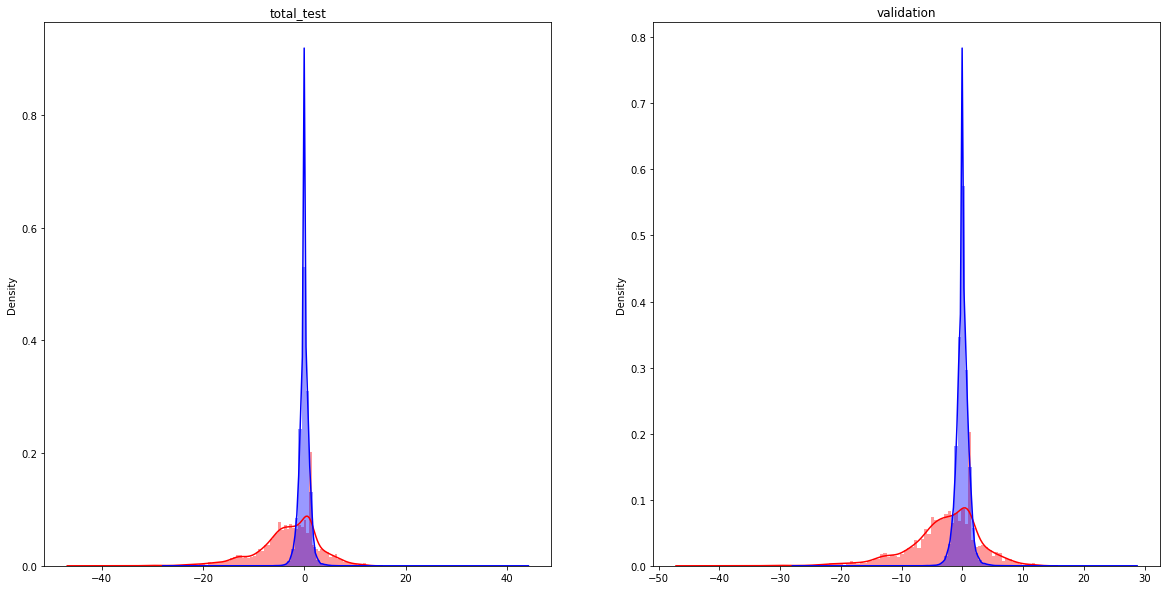

In [101]:
# 데이터별 분포 시각화
f, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].set_title(f'total_test')
axs[1].set_title(f'validation')

# Class가 0인 데이터만을 포함하는 학습데이터와 정상, 비정상 데이터가 섞인 테스트 데이터를 생성한다.
df_normal=df[df['Class'] == 0]
df_frud=df[df['Class'] == 1]
df_normal = df_normal.sample(frac=1).reset_index(drop=True)

# 정상거래만을 포함하는 학습 데이터
train_data_size = int(len(df_normal)*0.8)
train_df=df_normal[:train_data_size].drop(['Class'], axis=1)
train_target=df_normal[:train_data_size]['Class']

# 정상, 비정상 데이터가 섞인 테스트 데이터
test_df=df_normal[train_data_size:]
test_df=pd.concat([test_df, df_frud], axis=0,ignore_index=True).sample(frac=1).reset_index(drop=True)
sns.distplot(test_df[test_df['Class']==1], bins=100, color='red', ax=axs[0])
sns.distplot(test_df[test_df['Class']==0], bins=100, color='blue', ax=axs[0])

# threshold(cut-off)를 정하기 위한 validation 데이터
valid_data_size = int(len(test_df)*0.5)
valid_df=test_df[:valid_data_size]
valid_target=test_df[:valid_data_size]['Class']
sns.distplot(valid_df[valid_df['Class']==1], bins=100, color='red', ax=axs[1])
sns.distplot(valid_df[valid_df['Class']==0], bins=100, color='blue', ax=axs[1])
valid_df=valid_df.drop(['Class'], axis=1)

test_df=test_df[valid_data_size:]
test_target=test_df['Class']
test_df=test_df.drop(['Class'], axis=1)

우선 기본적으로 현재 사기거래의 분포는 다음과 같다. 알 수 있는 것은 사기거래 끼리는 확실하게 밀집해 있다는 것으로 이는 비교적 간단한 anomaly detection 방법론으로도 높은 성능을 보일 수 있다는 가능성이 높다고도 해석 할 수가 있다.

In [102]:
# 이후의 데이터 분석의 과정에서 데이터의 변수들이 모두 동일한 스케일을 갖도록 StandardScaler를 사용하여 스케일링한다.
scaler = StandardScaler()
scaler.fit(train_df)
train_df = scaler.transform(train_df)
valid_df = scaler.transform(valid_df)
test_df = scaler.transform(test_df)

In [103]:
train_df

array([[ 0.55201628, -0.80037224,  0.64920961, ...,  0.02018298,
        -0.73380957,  1.12594822],
       [-0.94732302, -0.55048443, -0.5510773 , ..., -1.07011261,
        -1.10996389,  2.04184637],
       [ 0.77427825,  0.26426885, -0.47369409, ..., -0.61978496,
         0.67765262, -1.49194395],
       ...,
       [ 0.84194994,  0.01037806,  0.56810595, ...,  0.03613614,
         0.28611144, -0.85604795],
       [ 0.95646192,  0.07499656,  0.53067771, ..., -0.02986372,
         0.50725043, -0.87822497],
       [ 0.69990333, -0.39778655, -0.94812802, ..., -0.5767454 ,
        -0.74420934,  2.13837199]])

In [104]:
test_df

array([[ 1.98398399,  2.03265171,  0.22894548, ...,  0.61481964,
        -0.46360943,  0.92083986],
       [ 0.35509537,  0.48652537, -0.3899576 , ..., -1.93448284,
         1.65001698, -3.12630352],
       [ 0.04558293,  0.65290085,  0.12042064, ..., -0.58906594,
        -0.09981898, -0.91501677],
       ...,
       [-0.28249985,  0.115199  , -0.48745471, ...,  0.60530243,
        -1.36411899,  0.76654246],
       [-0.5948261 , -1.28212302,  0.72814884, ...,  1.04997197,
         1.79848181, -1.4123812 ],
       [ 0.30118498, -0.9225717 ,  1.23323242, ...,  0.0165309 ,
         0.27462903,  1.25117043]])

## 1.2	Gaussian Density-based Anomaly Detection

 <p align="center">   <image src="./images/2022-11-16-23-39-51.png" width="60%"/>   </p>

가장 첫 째로 살펴볼 방법론인 Gaussian Density-based Anomaly Detection은 정상의 학습데이터가 기저에서 Gaussian distribution을 따른다는 가정에서 데이터가 생성되는 데 사용된 분포를 추정하고, 새로운 데이터가 해당 분포에서 생성될만 한지를 통해 Anomaly Detection을 수행한다. 한마디로 하자면 다음과 같다. "학습 데이터를 보니 이 데이터들은 평균 0이고 분산이 10인 Gaussian 분포를 따르는 거 같은데, 새로운 데이터의 값이 10000이니 이건 같은 분포에서 생성된 데이터는 아니겠다. 이건 이상치네!"  

실제 과정은 다음과 같이 1)Gaussian parameter 추정, 2) test 데이터의 Anomaly Score 산출로 이루어진다.  
 
1) Gaussian parameter 추정  
  : 학습데이터에 대해 Maximum Likelihood Estimation을 수행해 단순 계산으로 구한다.  

 <p align="center">   <image src="./images/2022-11-16-23-40-08.png" width="60%"/>   </p>

2) test 데이터의 Anomaly Score 산출  
  : 위에서 찾은 Gaussian parameter를 가지는 Gaussian Distribution에 대해 각 데이터의 확률을 계산하고, 그 확률이 특정 threshold 보다 작다면 이상치로 판단한다.

 <p align="center">   <image src="./images/2022-11-16-23-40-18.png" width="60%"/>   </p>


장점  
  
수식에서 보았듯이 쉽게 빠르게 연산이 가능한 방법론이며, 분포상의 확률이라는 직관적인 Anomaly Score를 제공한다. 또한 threshold를 조절하는 것을 통해 상황에 맞게 대응이 가능하다.

In [105]:
# Gaussian Density-based Anomaly Detection 코드 구현

#  1. Gaussian parameters 구하기
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    sigma = np.cov(X.T)
    return mu, sigma
    
#  2. Gaussian parameters를 이용하여 Anomaly Score 구하기
def multivariateGaussian(X, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(X)

#  3. Anomaly Score를 이용하여 Threshold 구하기-실제 데이터 포인트들의 발생확률을 기준으로 threshold를 변경시켜가며 최적의 threshold를 찾는다.
def selectThreshold(target, p):
    F1_list = []
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (max(p) - min(p)) / 1000
    for i, epsilon in enumerate(np.arange(min(p), max(p), stepsize)):
        print(f"Running iteration {i}/{len(np.arange(min(p), max(p), stepsize))} ...", end="\r")
        predictions = (p < epsilon)
        # class 간 불균형있고, 범주 중 사기거래 범주에 더욱 중요한 상황이므로 F1 score를 사용한다.
        F1 = f1_score(np.array(target), predictions, average = "binary")
        F1_list.append(F1)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    
    plt.plot(np.arange(min(p), max(p), stepsize), F1_list)
    return bestF1, bestEpsilon

In [106]:
# 정의한 함수를 통해 데이터의 변수에 따른 Gaussian parameters를 구한다.
mu, sigma = estimateGaussian(train_df)

print(f'mu: {mu}')
print(f'sigma: {sigma}')

mu: [ 1.14960399e-17  1.37452651e-18 -9.74664252e-18 -1.60569688e-17
  9.24681470e-18 -1.14335614e-17  4.24853649e-18  2.74905302e-18
  4.59216811e-18 -3.24888084e-18 -2.21173811e-17]
sigma: [[ 1.0000044   0.03847593 -0.08301117 -0.03502807 -0.07615484  0.04644603
  -0.08188869 -0.08078229 -0.0632484  -0.12182045 -0.04228144]
 [ 0.03847593  1.0000044   0.04130582  0.01922159  0.0403827  -0.02778324
   0.05133017  0.05503994  0.03773096  0.06916565  0.02436383]
 [-0.08301117  0.04130582  1.0000044  -0.03787322 -0.08664416  0.0461505
  -0.08616665 -0.08074915 -0.07429775 -0.13956311 -0.04846739]
 [-0.03502807  0.01922159 -0.03787322  1.0000044  -0.03451381  0.02142277
  -0.04004987 -0.04090808 -0.03338323 -0.06363678 -0.02047356]
 [-0.07615484  0.0403827  -0.08664416 -0.03451381  1.0000044   0.05070546
  -0.09538707 -0.0956629  -0.07434052 -0.14429457 -0.0478984 ]
 [ 0.04644603 -0.02778324  0.0461505   0.02142277  0.05070546  1.0000044
   0.06306903  0.06754089  0.04792851  0.08836489  0

In [109]:
# 정상 데이터만을 사용해 구한 Gaussian parameters를 이용하여 validation date가 다변량 가우시안 분포에 대해서 발생할 확률을 구한다.
# 이 확률을 이용하여 threshold를 구한다.
p_vaild = multivariateGaussian(valid_df,mu,sigma)
print(f'각 데이터의 발생확률 p: {p_vaild}, 데이터의 개수: {len(p_vaild)}')

각 데이터의 발생확률 p: [6.14200572e-08 6.80506509e-12 2.52263455e-06 ... 2.64494909e-06
 1.49707104e-07 1.90064632e-07], 데이터의 개수: 28677


(array([19371.,  4064.,  2615.,  1213.,   627.,   383.,   187.,   133.,
           61.,    23.]),
 array([0.00000000e+00, 4.05701223e-06, 8.11402445e-06, 1.21710367e-05,
        1.62280489e-05, 2.02850611e-05, 2.43420734e-05, 2.83990856e-05,
        3.24560978e-05, 3.65131100e-05, 4.05701223e-05]),
 <BarContainer object of 10 artists>)

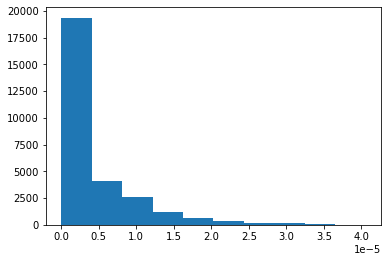

In [110]:
plt.hist(p_vaild)

fscore: 0.09102828244989698, ep: 4.0570122270760465e-08


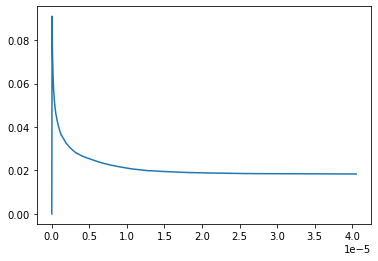

In [111]:
# 다음으로는 현재 계산된 p값 즉, Anomaly Score를 어느 기준에서 비정상 데이터로 판단할지 threshold를 구한다.
fscore, ep= selectThreshold(valid_target,p_vaild)
print(f'fscore: {fscore}, ep: {ep}')

그래프를 보면 알려진 바와 같이 방법론의 성능은 threshold에 따라 매우 크게 달라지며, 모든 지점에서 성능이 매우 떨어진다. 그러나 이는 아래의 그래프 분포를 볼때, 1000개의 stepsize가 부족하기 때문인 것으로 보인다.

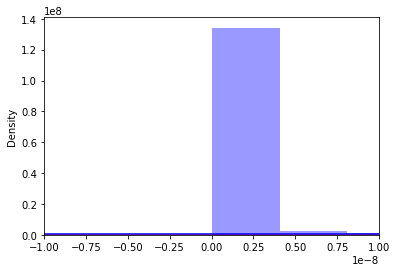

In [136]:
valid_for_threshold=pd.DataFrame(valid_target.copy())
valid_for_threshold['p']=p_vaild
sns.distplot(valid_for_threshold[valid_for_threshold['Class']==1], bins=10000, color='red')
sns.distplot(valid_for_threshold[valid_for_threshold['Class']==0], bins=10000, color='blue')
plt.xlim(-0.00000001, 0.00000001)
plt.show()

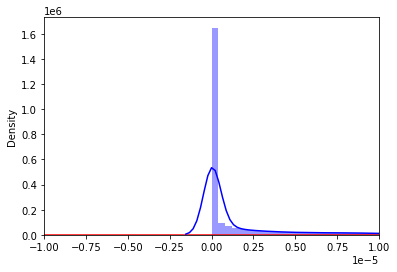

In [128]:
sns.distplot(valid_for_threshold[valid_for_threshold['Class']==1], bins=100, color='red')
sns.distplot(valid_for_threshold[valid_for_threshold['Class']==0], bins=100, color='blue')
plt.xlim(-0.00001, 0.00001)
plt.show()

In [127]:
valid_for_threshold['Class'].value_counts()

0    28411
1      266
Name: Class, dtype: int64

위 그림과 값의 크기를 고려하였을때 1보다 크면서 매우 가까운 threshold가 필요함을 할 수 있다. 이 값은 거의 1e-50 수준의 값이므로 직접 탐색은 어려우니  
라이브러리를 통해 구한 값과 비교해보려고한다.

In [135]:
p_test = multivariateGaussian(test_df,mu,sigma)
predictions = (p_test < 1.0527717316e-70)
# class 간 불균형있고, 범주 중 사기거래 범주에 더욱 중요한 상황이므로 F1 score를 사용한다.
F1 = f1_score(np.array(test_target), predictions, average = "binary")
print(f'F1 score: {F1}')

F1 score: 0.8461538461538461


데이터의 분포를 통해 예상한 대로 간단한 방법론 구조에 비해 매우 높은 F1 score를 보이고 있다. 그러나 현실적으로 본 데이터에서 naive하게 threshold를 탐색하는 것은 좋은 방법이 아닌것으로 보인다.

## 1.3	Mixture of Gaussians Density Estimation
앞서 설명한 Gaussian Density-based Anomaly Detection 방법론의 경우 쉽게 적용 가능하다는 것이 장점이지만, 다소 세상을 너무 쉽게 본 경향이 있다. 과연 실제 현실의 데이터가 하나의 정규분포로부터 발생하였을까? 세상의 다양한 현상들이 크게 보면 정규 분포를 따르는 경향이 있는 것은 분명하지만, 확실하게 다수의 분포로부터 데이터가 발생했다고 보는 것이 더 정확한 경우는 많이 있다. 간단한 예시를 들어보면 사람의 신장에 대한 분포를 살펴본다면 나름대로 Gaussian 분포를 따를 수도 있지만, 성별에 따라 조금 다른 분포를 보일 수 있다는 건 쉽게 생각할 수 있다. 또 만약 국가가 달라진다면 국민들의 키가 키기로 유명한 북유럽 국가 국민들의 키 분포와 우리나라의 키 분포가 과연 하나의 단봉(분포의 모양이 봉우리가 하나라는 의미) Gaussian 분포를 이룰까? 이런 상황을 분석하기 위해서 우리는 여러 개의 Gaussian 분포를 선형 결합한 Mixture of Gaussians를 사용하곤 한다. 이 아이디어를 Anomaly Detection에 적용한 것이 이번에 알아볼 Mixture of Gaussians Density Estimation 방법론이다.  

 <p align="center">   <image src="./images/2022-11-16-23-40-36.png" width="60%"/>   </p>

데이터에 대해 추정하는 분포가 단봉이 아니라 multi-mode(다봉)라는 것만 제외한다면 Anomaly Detection의 아이디어는 동일하다. 데이터를 통해 추정한 분포에 대해서 새로운 test 데이터가 발생할 확률이 작다면 이상치로 판단하는 것이다.  

가장 큰 차이가 발생하는 부분은 분포의 파라미터(모수, parameter)를 추정하는 과정이 단봉이었을 때와는 다르게 한 번에 최적화가 불가능하고 EM알고리즘을 통해 순차적으로 찾아가야 한다는 것이다. 기존의 단봉 상황에선 모든 데이터가 하나의 가우시안 분포로부터 기인했다는 가정을 하기 때문에 모든 데이터를 사용하여 Maximum Likely Estimation을 통해 단순 계산으로 파라미터를 구할 수 있었다. 그러나 현재 multi-mode 상황에서는 어떤 데이터가 어떤 mode로부터 생성되었는지를 알지 못해, 어떤 데이터를 통해 어떤 mode의 파라미터를 계산해야 하는지 알 수가 없다. 또한 각각의 mode가 결합되는 비율도 알 수가 없다. EM 알고리즘은 Expectation–maximization algorithm의 줄임 말로 지금처럼 한 번에 최적화가 불가능한 상황에서 Expectation, maximization 과정을 반복하는 것으로 최적화를 수행하는 대표적인 방법이다.  

각각의 과정은 다음과 같은 역할을 수행한다.  
- Expectation: 현재 시점의 파라미터를 사용해 어떤 데이터가 어떤 가우시안 분포에 할당되어야 최대 likelihood를 가지는 지를 통해 데이터를 mode에 할당  

 <p align="center">   <image src="./images/2022-11-16-23-41-09.png" width="60%"/>   </p>

- Maximization: 현재 할당된 데이터를 기분으로 likelihood를 최대화하도록 각 가우시안 분포의 파라미터 업데이트  

 <p align="center">   <image src="./images/2022-11-16-23-41-30.png" width="60%"/>   </p>
 
즉, 최적화의 과정을 정리하면 다음과 같다.  

1)	가우시안 파라미터 랜덤 초기화  
2)	Expectation  
3)	Maximization  
4)	E-M 과정 정해진 수만큼 반복  
추가로 전체적인 수식은 다음과 같다.  

 <p align="center">   <image src="./images/2022-11-16-23-41-49.png" width="60%"/>   </p>

추가로 연산 효율을 위해 다양한 형태의 공분산 행렬 사용 가능하며 공분산 행렬 형태에 따라 다양한 Mixture of Gaussians 형태가 발생한다.  

 <p align="center">   <image src="./images/2022-11-16-23-42-03.png" width="60%"/>   </p>

In [14]:
# Mixture of Gaussians Density Estimation 코드 구현
# 본 방법론의 경우도 Gaussian Density-based Anomaly Detection과 마찬가지로 Gaussian parameters를 구하는 과정이 필요하다.
# 다만, 본 방법론은 Gaussian parameters를 구하는 과정에서 EM 알고리즘을 사용한다.

# 1. M-step Gaussian parameters 구하기
# 먼저 파라미터 초기화를 위한 함수를 정의한다.

class theta():
    def __init__(self, pi, mu, Sigma):
        self.pi = pi
        self.mu = mu
        self.Sigma = Sigma

# 다음으로 각각의 파라미터를 계산하기위한 함수를 정의한다.
def get_gamma(theta_val, X, K):
    gamma = np.empty((0,K))

    for n in range(len(X)):
        gamma_n = np.array([])

        for k in range(K):
            denom_elem = np.array([])
            for j in range(K):
                dist_j = multivariate_normal(
                    mean=theta_val.mu[j],
                    cov=theta_val.Sigma[j])
                denom_elem = np.append(denom_elem, theta_val.pi[j] * dist_j.pdf(X[n]))
            denom = denom_elem.sum()

            dist_k = multivariate_normal(
                mean=theta_val.mu[k],
                cov=theta_val.Sigma[k])
            numer = theta_val.pi[k] * dist_k.pdf(X[n])

            gamma_n = np.append(gamma_n, numer / denom)

        gamma = np.vstack((gamma, gamma_n))

    return gamma

def get_mu(gamma, X, K):
    mu_new = np.zeros((K,X.shape[1]), dtype=np.float64)

    for k in range(K):
        denom = sum(gamma[n][k] for n in range(len(X)))
        numer_x = sum(gamma[n][k] * X[n][0] for n in range(len(X)))
        mu_new[k][0] = numer_x / denom
        numer_y = sum(gamma[n][k] * X[n][1] for n in range(len(X)))
        mu_new[k][1] = numer_y / denom

    return mu_new

def get_sigma(gamma, mu_new, X, K):
    Sigma_new = np.empty((0,X.shape[1],X.shape[1]))

    for k in range(K):
        denom = sum(gamma[n][k] for n in range(len(X)))
        numer = np.zeros((X.shape[1],X.shape[1]), dtype=np.float64)
        for n in range(len(X)):
            sub = np.subtract(X[n], mu_new[k])
            sub = np.array([sub])
            sub_t = sub.transpose()
            numer = numer + gamma[n][k] * np.matmul(sub_t, sub)
        Sigma_new = np.vstack((Sigma_new, [numer / denom]))

    return Sigma_new

def get_pi(gamma, X, K):
    pi_new = np.array([])

    for k in range(K):
        pi_new = np.append(
            pi_new,
            sum(gamma[n][k] for n in range(len(X))) / len(X))

    return pi_new

In [139]:
# 가우시안의 갯수 K는 하이퍼 파라미터이므로 미리 정의해 준다. 
# 직전의 단봉 모델에서 이미 좋은 성능을 보인 것으로 보아, 많은 수의 가우시안을 사용하는 것은 좋지 않을 것으로 예상되므로 K=3로 설정한다.
K = 3

cov=np.ones(K*train_df.shape[1]*train_df.shape[1]).reshape(K,train_df.shape[1],train_df.shape[1])
for i in range(K):
    cov[i]=np.stack(np.cov(train_df, rowvar=False), axis=0)


#파라미터 초기화
theta_old = theta(
    pi=np.random.dirichlet(np.ones(K),size=1)[0],
    mu=np.random.random(K*train_df.shape[1]).reshape(K,train_df.shape[1]),
    Sigma=cov,
    )

0        0
1        0
2        0
3        0
4        0
        ..
28672    0
28673    0
28674    0
28675    0
28676    0
Name: Class, Length: 28677, dtype: int64

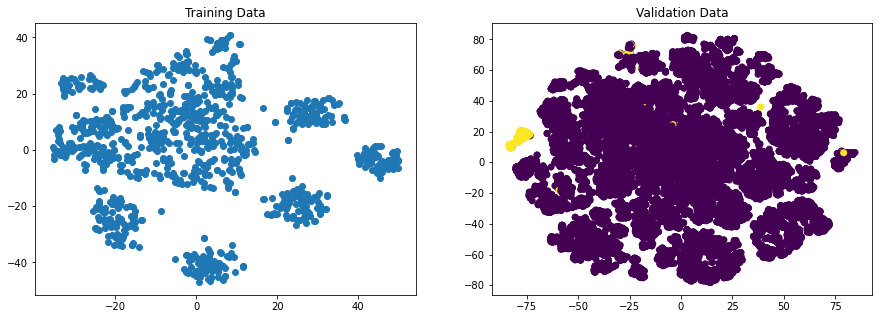

In [164]:
# 빠른 학습을 위해 데이터를 샘플링한다.
train_df_sample = train_df[0:1000]
train_sample_low=TSNE(n_components=2).fit_transform(train_df_sample)
train_sample_low_df=pd.DataFrame(train_sample_low,columns=['x1','x2'])


# 이상치가 존재하는 validation 데이터의 경우
valid_sample_low=TSNE(n_components=2).fit_transform(valid_df)
valid_sample_low_df=pd.DataFrame(valid_sample_low,columns=['x1','x2'])
valid_sample_low_df['Class']=valid_target

f,axs=plt.subplots(1,2,figsize=(15,5))

axs[0].scatter(train_sample_low_df['x1'],train_sample_low_df['x2'])
axs[0].set_title('Training Data')
axs[1].scatter(valid_sample_low_df['x1'],valid_sample_low_df['x2'], c=valid_sample_low_df['Class'])
axs[1].set_title('Validation Data')

plt.show()


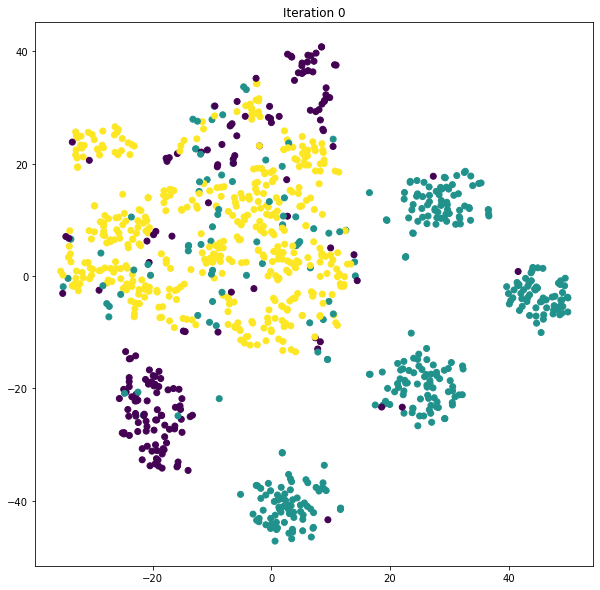

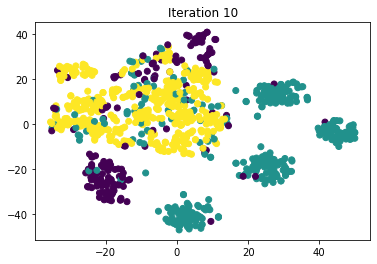

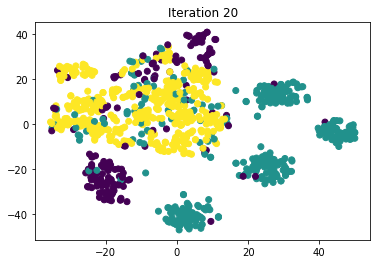

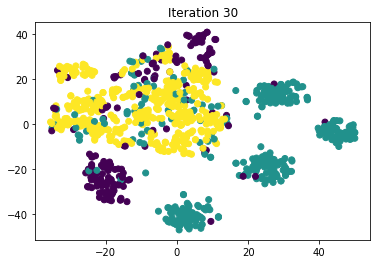

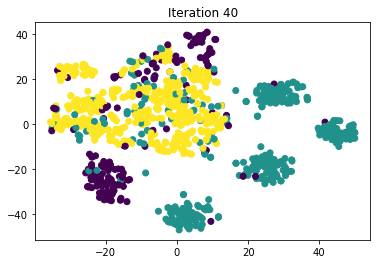

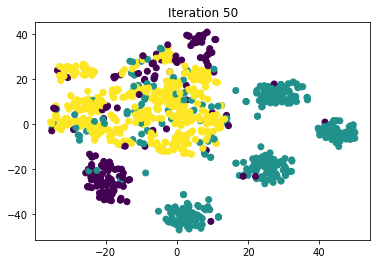

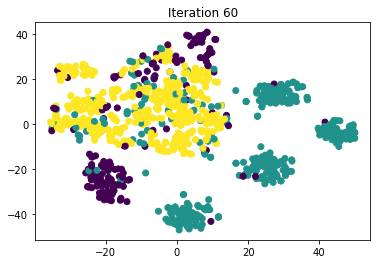

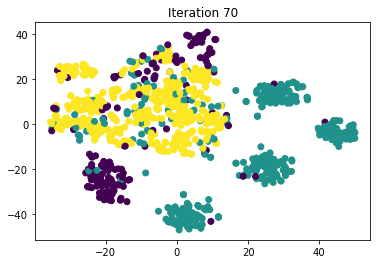

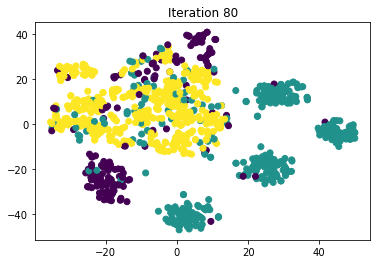

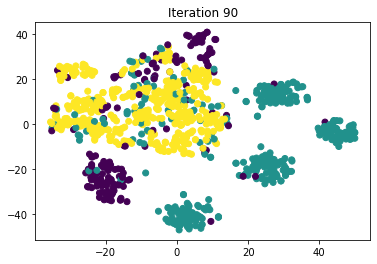

pi:[0.17525063 0.38363298 0.4411164 ], mu:[[-0.72921941 -0.09071437  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.01840242 -0.38440438  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.29021069  0.3162692   0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]], Sigma:[[[ 1.63992633e+00  1.12030022e-01  2.87417281e-01 -1.96287906e-01
   -1.42891166e-01  2.74667056e-01 -2.52718807e-01 -4.90925389e-01
   -3.85429835e-01 -6.27859231e-01 -1.35859815e-01]
  [ 1.12030022e-01  9.39333979e-01 -7.70924623e-02 -5.52086544e-01
   -5.24402761e-01  5.34686893e-02 -8.51437086e-02 -3.38450213e-01
    1.35212395e-01  6.52438089e-01  2.91501088e-01]
  [ 2.87417281e-01 -7.70924623e-02  1.48011991e+00  3.63792775e-01
    3.16639656e-01  5.56360383e-01 -4.27110261e-01 -1.12820618e+00
   -3.80551960e-01 -2.31619584e-01 -9.95269846e-02]
  [-1

In [181]:
# EM 알고리즘 수행

figure= plt.figure(figsize=(10,10))

for loop in range(100):
    print(f"Running iteration {loop + 1} ...", end="\r")
    # Get gamma
    l_gamma = get_gamma(theta_old, train_df_sample,K)
    estimated_gaussian=np.argmax(l_gamma,axis=1) # 가장 높은 확률을 가진 가우시안을 선택한다.
    train_sample_low_df['estimated_gaussian']=estimated_gaussian

    # Get new mu
    l_mu_new = get_mu(l_gamma,train_df_sample,K)
    # Get new sigma
    l_sigma_new = get_sigma(l_gamma, l_mu_new,train_df_sample,K)
    # Get new pi
    l_pi_new = get_pi(l_gamma,train_df_sample,K)
    # Replace theta
    theta_old = theta(
        pi=l_pi_new,
        mu=l_mu_new,
        Sigma=l_sigma_new
    )
    if loop%10 == 0:
        plt.title(f"Iteration {loop}")
        plt.scatter(train_sample_low_df['x1'],train_sample_low_df['x2'],c=train_sample_low_df['estimated_gaussian'])
        plt.show()

print(f"pi:{theta_old.pi}, mu:{theta_old.mu}, Sigma:{theta_old.Sigma}")

EM 알고리즘이 진행되며 점점 그럴듯한 방향으로 각 데이터가 가우시안에 할당되는 것을 볼 수 있다.

In [187]:
# 학습된 파라미터를 받아서 테스트 데이터에 대한 예측값을 구하는 함수를 정의한다.

pi=theta_old.pi
mu=theta_old.mu
Sigma=theta_old.Sigma

pi.shape, mu.shape, Sigma.shape


((3,), (3, 11), (3, 11, 11))

In [188]:
#얻은 파라미터를 통해 최종적인 분포를 얻고, 이를 통해 테스트 데이터에 사용할 threshold를 구한다.
prob = pi[0]*multivariate_normal(mean=mu[0], cov=Sigma[0]).pdf(valid_df)+pi[1]*multivariate_normal(mean=mu[1], cov=Sigma[1]).pdf(valid_df)+pi[2]*multivariate_normal(mean=mu[2], cov=Sigma[2]).pdf(valid_df)
prob

array([3.36899261e-05, 1.73627958e-09, 2.37267851e-04, ...,
       6.88247684e-04, 6.94867866e-07, 1.23679219e-08])

fscore: 0.029423237670660355, ep: 1.0788434230910546e-05


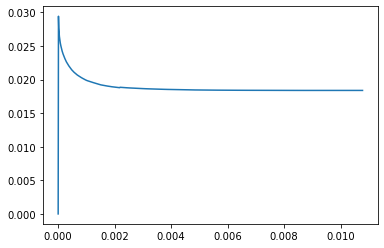

In [189]:
#이후의 과정은 가우시안이 한개일 때와 동일하게 진행된다.
# 다음으로는 현재 계산된 p값 즉, Anomaly Score를 어느 기준에서 비정상 데이터로 판단할지 threshold를 구한다.
fscore, ep= selectThreshold(valid_target,prob)
print(f'fscore: {fscore}, ep: {ep}')

#이전의 단봉과 유사하게 적절한 threshold를 찾는데 어려움을 보인다. 이번에는 이전 단봉에서 사용했던 방법과는 다르게 라이브러리를 활용하여 threshold를 구해보자.

In [200]:
# 최종적인 분포는 다음과 같이 sklearn 라이브러리의 GaussianMixture class에 우리가 구한 Parameter를 넣어서도 얻을 수 있다. 
gmm=GaussianMixture(n_components=3, random_state=0)
gmm.weights_=pi
gmm.means_=mu
gmm.covariances_=Sigma
gmm.fit(train_df)
# gmm.fit()
# 이 경우가 이후에 데이터를 바꾸며 실험하기가 더 편하므로 이를 사용한다.

GaussianMixture(n_components=3, random_state=0)

fscore: 0.8524590163934427, ep: -59.32545143678885


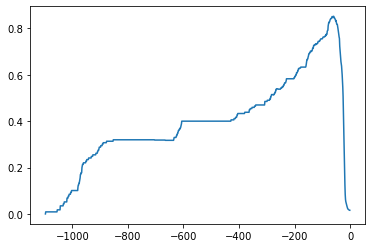

In [201]:
# GaussianMixture class를 사용하면 아래와 같이 per-sample average log-likelihood를 구할 수 있다.
score = gmm.score_samples(test_df)
fscore, ep= selectThreshold(test_target,score)
print(f'fscore: {fscore}, ep: {ep}')

In [205]:
gmm.weights_, gmm.means_, gmm.covariances_

(array([0.20631121, 0.31403938, 0.4796494 ]),
 array([[-0.10981002, -0.2558093 , -0.07750829,  0.288267  ,  0.27964378,
          0.18124145, -0.78493522,  0.4690574 , -0.32462131,  0.33799008,
          0.3736834 ],
        [-0.23138491,  0.03577947, -0.34487537,  0.02442412,  0.32530659,
         -0.02448699,  0.25648852,  0.08564901, -0.07197459, -0.24457969,
         -0.18658568],
        [ 0.19872643,  0.08660527,  0.25913777, -0.13998318, -0.33326994,
         -0.06192495,  0.16969361, -0.257832  ,  0.18675281,  0.01475351,
         -0.03856947]]),
 array([[[ 1.92172953e+00, -1.54879919e-01, -2.18067162e-01,
          -8.97042625e-02, -1.31008836e-01,  1.70364871e-01,
          -6.00876721e-01, -2.92582797e-01, -3.74680722e-01,
          -1.35310287e-01,  1.74780672e-01],
         [-1.54879919e-01,  1.63774818e+00,  1.01822615e-02,
           2.28236258e-01, -1.88648123e-01,  1.45386066e-01,
          -3.04383095e-01,  3.66760281e-01,  3.13281415e-01,
           2.85367357e-01, -

요약하자면 현재의 데이터는 이상치가 나름대로 유사한 특징을 가지고 밀집한 형태를 보이기 때문에 간단한 모델들에서도 높은 성능을 보이며, 값의 크기가 매우 작다는 특징 때문에 threshold를 찾는 것에 어려움이 있다.  
이 경우 GaussianMixture class의 score 처럼 scale이 더 커지면 해결이 가능하다.

## 1.4	Auto Encoder
우선 Auto-Encoder 자체에 대해 이야기 해보자. Auto-Encode란 입력과 출력이 동일한 Encoder & Decoder 구조의 인공신경망이다.

 <p align="center">   <image src="./images/2022-11-16-23-58-39.png" width="60%"/>   </p>

위 그림에서도 확인이 가능한데, 모델의 input과 output이 모두 X로 동일하다. 또한 아래의 그림을 보면 입력과 출력의 크기가 동일한 것에 비해 중간의 latent Vector는 더 적은 차원을 가진 것을 확인 할 수 있다.

 <p align="center">   <image src="./images/2022-11-17-00-01-14.png" width="60%"/>   </p>

이는 입력 변수보다 적은 차원의 Latent Space를 거치는 것으로 정보의 축약을 수행하는 것으로, 모델은 이처럼 입력을 축약하는 Mapping 과정과 그를 다시 복원하는 de-mapping 과정을 거친다. 모델의 학습은 입력과 출력이 최대한 동일해지도록 수행되며, 이 과정을 통해 모델은 입력 데이터를 보다 확실히 이해할 수 있게된다.

 <p align="center">   <image src="./images/2022-11-17-00-05-29.png" width="60%"/>   </p>

이런 Auto-Encoder의 활용은 크게 두가지가 있는데, 첫 째로는 데이터 차원 축소 도구로써 역할을 수행하여 latent vector가 다른 ML 모델의 input으로 사용되도록 하는 경우이다. 두 번째는 이번 실습의 주제인 Anomaly Detection을 수행하는 것인데, 기본적인 Anomaly detection 학습의 과정과 동일하게 모델은 정상 데이터만을 통해 학습이 되므로 모델은 정상 데이터를 압축, 복원하는 방법을 익히게 된다. 즉, 새로이 비정상 데이터가 들어온다면 모델을 통과한 결과 제대로 복원되지 못할 것이고, Reconstruction Loss가 큰게 나타나게 된다.

 <p align="center">   <image src="./images/2022-11-17-02-12-04.png" width="60%"/>   </p>

Auto-Encoder의 장점은 복원되는 정도가 어느 위치에서 영향을 받는지 확인이 가능하다는 점이 있는데, 이는 위 그림에서 잘 나타난다.

In [208]:
# 이번에 알아볼 Auto-encoder는 pytorch를 사용하여 쉽게 구현할 수 있다.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


현재 data의 feature의 수가 11개 이므로 Auto-encoder는 11개의 input과 11개의 output을 가지는 구조로 만들어 져야하며,  
latent space는 11개 보다 작은 수로 구성되어야한다.

In [210]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11, 7),
            nn.ReLU(True),
            nn.Linear(7, 5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(5, 7),
            nn.ReLU(True),
            nn.Linear(7, 11),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [213]:
train_df

array([[ 0.55201628, -0.80037224,  0.64920961, ...,  0.02018298,
        -0.73380957,  1.12594822],
       [-0.94732302, -0.55048443, -0.5510773 , ..., -1.07011261,
        -1.10996389,  2.04184637],
       [ 0.77427825,  0.26426885, -0.47369409, ..., -0.61978496,
         0.67765262, -1.49194395],
       ...,
       [ 0.84194994,  0.01037806,  0.56810595, ...,  0.03613614,
         0.28611144, -0.85604795],
       [ 0.95646192,  0.07499656,  0.53067771, ..., -0.02986372,
         0.50725043, -0.87822497],
       [ 0.69990333, -0.39778655, -0.94812802, ..., -0.5767454 ,
        -0.74420934,  2.13837199]])

 epoch [1/1000], loss:0.7919, val_loss:1.2538
 epoch [2/1000], loss:0.7915, val_loss:1.2532
 epoch [3/1000], loss:0.7911, val_loss:1.2527
 epoch [4/1000], loss:0.7907, val_loss:1.2521
 epoch [5/1000], loss:0.7903, val_loss:1.2516
 epoch [6/1000], loss:0.7898, val_loss:1.2510
 epoch [7/1000], loss:0.7894, val_loss:1.2504
 epoch [8/1000], loss:0.7890, val_loss:1.2499
 epoch [9/1000], loss:0.7886, val_loss:1.2493
 epoch [10/1000], loss:0.7882, val_loss:1.2487
 epoch [11/1000], loss:0.7877, val_loss:1.2481
 epoch [12/1000], loss:0.7873, val_loss:1.2475
 epoch [13/1000], loss:0.7869, val_loss:1.2470
 epoch [14/1000], loss:0.7865, val_loss:1.2464
 epoch [15/1000], loss:0.7860, val_loss:1.2458
 epoch [16/1000], loss:0.7856, val_loss:1.2452
 epoch [17/1000], loss:0.7851, val_loss:1.2446
 epoch [18/1000], loss:0.7847, val_loss:1.2441
 epoch [19/1000], loss:0.7843, val_loss:1.2435
 epoch [20/1000], loss:0.7838, val_loss:1.2429
 epoch [21/1000], loss:0.7834, val_loss:1.2423
 epoch [22/1000], loss

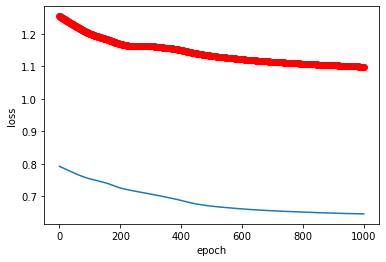

In [218]:
train_input=torch.from_numpy(train_df).float()
valid_input=torch.from_numpy(valid_df).float()
test_input=torch.from_numpy(test_df).float()

# 학습을 진행한다.
num_epochs = 1000
loss_list=[]
val_loss_list=[]
for epoch in range(num_epochs):
    # ===================forward=====================
    output = model(train_input)
    loss = criterion(output, train_input)
    loss_list.append(loss.item())
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # ===================log========================
    val_output=model(valid_input)
    val_loss=criterion(val_output, valid_input)
    val_loss_list.append(val_loss.item())
    print(' epoch [{}/{}], loss:{:.4f}, val_loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss.item()))

plt.plot(np.arange(num_epochs),loss_list)
plt.plot(np.arange(num_epochs),val_loss_list,'ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

우선적으로 1000번으로는 아직 학습이 완료되지 않은 모습을 보이므로 추가학습을 수행해야 한다.  

추가로 주목할 점은 정상 데이터만 존재하는 train data의 결과와 비정상 데이터가 존재하는 validation data의 loss 결과가 처음부터 함께 감소하나 일정 수준이상 차이가 나는것이다.  
이는 validation data에 포함된 비정상데이터 때문에 발생하는 것으로 유추할 수 있으므로, 이상치 탐지 결과가 좋게 나올 수 있다는 예상을 가능하게 한다.


 epoch [1/1000], loss:0.6454, val_loss:1.0982
 epoch [2/1000], loss:0.6454, val_loss:1.0982
 epoch [3/1000], loss:0.6454, val_loss:1.0981
 epoch [4/1000], loss:0.6453, val_loss:1.0981
 epoch [5/1000], loss:0.6453, val_loss:1.0980
 epoch [6/1000], loss:0.6453, val_loss:1.0980
 epoch [7/1000], loss:0.6453, val_loss:1.0979
 epoch [8/1000], loss:0.6453, val_loss:1.0979
 epoch [9/1000], loss:0.6452, val_loss:1.0978
 epoch [10/1000], loss:0.6452, val_loss:1.0978
 epoch [11/1000], loss:0.6452, val_loss:1.0978
 epoch [12/1000], loss:0.6452, val_loss:1.0977
 epoch [13/1000], loss:0.6452, val_loss:1.0977
 epoch [14/1000], loss:0.6451, val_loss:1.0976
 epoch [15/1000], loss:0.6451, val_loss:1.0976
 epoch [16/1000], loss:0.6451, val_loss:1.0975
 epoch [17/1000], loss:0.6451, val_loss:1.0975
 epoch [18/1000], loss:0.6451, val_loss:1.0974
 epoch [19/1000], loss:0.6450, val_loss:1.0974
 epoch [20/1000], loss:0.6450, val_loss:1.0974
 epoch [21/1000], loss:0.6450, val_loss:1.0973
 epoch [22/1000], loss

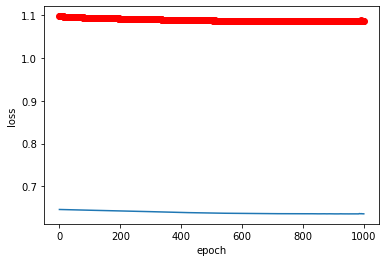

In [219]:
# 추가 학습을 진행한다.
num_epochs = 1000
loss_list=[]
val_loss_list=[]
for epoch in range(num_epochs):
    # ===================forward=====================
    output = model(train_input)
    loss = criterion(output, train_input)
    loss_list.append(loss.item())
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # ===================log========================
    val_output=model(valid_input)
    val_loss=criterion(val_output, valid_input)
    val_loss_list.append(val_loss.item())
    print(' epoch [{}/{}], loss:{:.4f}, val_loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss.item()))

plt.plot(np.arange(num_epochs),loss_list)
plt.plot(np.arange(num_epochs),val_loss_list,'ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

아직도 성능을 증가하는 경향을 보이나, 큰 차이가 없으므로 현재 상태에서 anomaly detection 실험을 수행해 보자.

In [257]:
# 학습이 끝난 후, 학습된 모델을 통해 테스트 데이터의 Anomaly Score를 구한다.
output = model(valid_input)
reconstruction_error = nn.MSELoss(reduction='none')
error = reconstruction_error(output, valid_input)
e=torch.sum(error,dim=1).detach().numpy()
e.shape

(28677,)

<AxesSubplot:ylabel='Density'>

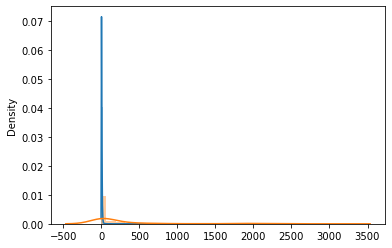

In [258]:
# validation set을 통해 threshold를 구한다.
valid_label=pd.DataFrame(valid_target)
valid_label['error']=e
sns.distplot(valid_label[valid_label['Class']==0])
sns.distplot(valid_label[valid_label['Class']==1])


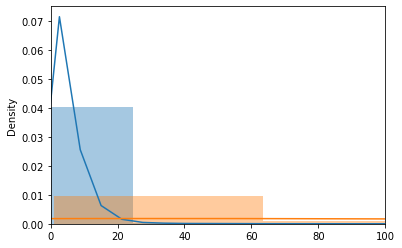

In [259]:
valid_label=pd.DataFrame(valid_target)
valid_label['error']=e
sns.distplot(valid_label[valid_label['Class']==0])
sns.distplot(valid_label[valid_label['Class']==1])

plt.xlim(0, 100)
plt.show()

분포가 다음과 같으므로 0~100 사이의 threshold를 탐색해 보자

In [254]:
def selectThreshold2(target, p):
    F1_list = []
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (100 - 0) / 1000
    for i, epsilon in enumerate(np.arange(0,100, stepsize)):
        print(f"Running iteration {i}/{len(np.arange(0,100, stepsize))} ...", end="\r")
        predictions = (p < epsilon)
        # class 간 불균형있고, 범주 중 사기거래 범주에 더욱 중요한 상황이므로 F1 score를 사용한다.
        F1 = f1_score(np.array(target), predictions, average = "binary")
        F1_list.append(F1)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    
    plt.plot(np.arange(0,100, stepsize), F1_list)
    return bestF1, bestEpsilon

fscore: 0.0036243247952604985, ep: 97.5


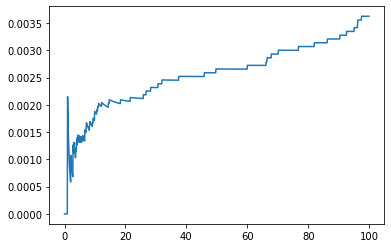

In [255]:
fscore, ep= selectThreshold2(test_target,e)
print(f'fscore: {fscore}, ep: {ep}')

# 다음은 추가적으로 살펴볼 만한 이론을 정리한 것이다. 추후에 코드 실습도 추가될 예정이다.
# 1.5 DAGMM
마지막으로 기본적인 방법론들에서 조금 더 나아가 살펴볼 모델은 앞서 설명한 Mixture of Gaussians Density Estimation과 Auto-Encoder를 함께 사용하는 DEEP AUTOENCODING GAUSSIAN MIXTURE MODEL 이다. 본 방법론은 DEEP AUTOENCODING GAUSSIAN MIXTURE MODEL FOR UNSUPERVISED ANOMALY DETECTION (Zong et al., ICLR 2018) 논문에서 제안된 방식으로 전체적인 구조는 아래와 같다.

 <p align="center">   <image src="./images/2022-11-17-02-20-58.png" width="60%"/>   </p>

그림에서 알 수 있듯이 Auto-Encoder로 구성된 Compression Network와 Mixture of Gaussians Density Estimation의 Estimation역할을 수행하는 Estimation Network로 구성되는 모델로, Auto-Encoder의 또 다른 활용법인 차원축소를 통해 얻은 저차원의 결과를 Mixture of Gaussians Density Estimation에 활용한다고 보면 된다.  

하나 짚고 넘어갈 점은 일전 Mixture of Gaussians Density Estimation를 설명할 때, EM 알고리즘은 Expectation & Maximization의 약자라고 설명하였으나 본 논문에서는 Estimation으로 용어를 사용하고 있다. 실제로 의미가 비슷하기도 하고 다양한 출처에서 둘을 혼용하고 있으니 참고바란다.  

DAGMM의 지적하는 기존 방법론의 문제점은 바로 이 EM 알고리즘을 통해 최적화되야 한다는 점으로, 본 방법론은 end-to-end 학습이 가능한 구조이다. Auto-Encoder가 사용되는 부분은 차원의 축소를 담당하는 것으로 이상치 탐지에는 비교적 직접적으로 사용되지는 않으며 핵심은 Estimation Network에 있다. 이 Estimation Network는 MLN이 반복되고 마지막에 Softmax layer가 있는 구조로 Compression Network의 결과를 받아 최종적으로 각각의 데이터 포인트가 어떤 가우시안 mode에 포함될지를 확률의 형태로 산출해 준다. 기존의 GMM에 EM 알고리즘이 필요했던 이유는 각 데이터가 어떤 mode에 속하는지 결정이 되어야 가우시안의 파라미터를 계산할 수가 있고, 동시에 각 가우시안의 파라미터가 결정이 되어있어야 데이터들의 likelyhood를 계산 할 수 있기 때문에 동시에 최적화가 불가능 하다는 것이었다. 그러나 DAGMM 처럼 모델의 output에 직접적으로 각 데이터 포인트가 어떤 mode에 속하는지를 확률로 알려준다면 그를 활용해 바로 가우시안 분포의 파라미터 추정할 수가 있고 최종적으로 Objective function 최적화를 수행할 수가 있다.

전체적인 Process와 계산식은 다음과 같다.

 <p align="center">   <image src="./images/2022-11-17-02-34-10.png" width="60%"/>   </p>

특징적인 부분만을 일부 더 살펴보면 Compression Network에서는 일반적인 차원 축소의 결과로 latent vector만을 사용하는 것과는 다르게, Auto-Encoder 입력과 출력 사이의 cos similarity와 L2 norm을 계산한 것을 concatenation하여 사용한다는 것이다.  

또 Loss를 보면 크게 세 가지 부분으로 구분이 되는데, 순서대로 Auto-Encoder 학습을 담당하는 Reconstruction error, Likelihood와 유사하게 작동하여 input을 관측할 확률이 높아지도록 하는 Sample energy Function이 있으며, 마지막으로는 GMM과 동일하게 특정한 position에서 data의 발생확률이 지나치게 높게 학습되는 특이점 문제를 방지하기 위해 공분산 행렬의 대각의 값들이 0이 되는 것을 방지하는 Penalized Diagonal Entries term이 있다.

Reference
DEEP AUTOENCODING GAUSSIAN MIXTURE MODEL FOR UNSUPERVISED ANOMALY DETECTION (Zong et al., ICLR 2018)

https://www.kaggle.com/code/shelars1985/anomaly-detection-using-gaussian-distribution/notebook

https://github.com/tsmatz/gmm/blob/master/01-gmm-em-algorithm.ipynb
